In [2]:
# preparation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
%matplotlib inline

from prml.clustering import KMeans
from prml.rv import (
    MultivariateGaussianMixture,
    BernoulliMixture
)

np.random.seed(2222)


如果我们定义观测变量和潜在变量的一个联合概率分布，那么对应的观测变量本身的概率分布可以通过求边缘概率的方法得到。这使得观测变量上的复杂的边缘概率分布可以通过观测变量与潜在变量组成的扩展空间上的更加便于计算的联合概率分布来表示。因此，潜在变量的引入使得复杂的概率分布可以由简单的分量组成。本章中，我们会看到混合概率分布（例如2.3.9节讨论的高斯混合模型）可以用离散潜在变量来表示。连续潜在变量是第12章的主题。

除了提供了一个构建更复杂的概率分布的框架之外，混合模型也可以用于数据聚类。因此，在开始讨论混合概率分布时，我们会考虑寻找数据点集合中的聚类的问题。我们首先使用一个非概率的方法解决这个问题，这个方法被称为K均值算法（Lloyd， 1982）。之后，我们引入混合概率分布的潜在变量观点，其中离散潜在变量可以被看做将数据点分配到了混合概率分布的具体成分当中。潜在变量模型中寻找最大似然估计的一个一般的方法是期望最大化（EM）算法。我们首先使用高斯混合分布，以一种相当非形式化的方式介绍EM算法，然后我们会基于潜在变量的观点，给出一个更加仔细的处理方法。我们会看到，K均值算法对应于用于高斯混合模型的EM算法的一个特定的非概率极限。最后，我们会以一种一般的方式讨论EM算法。

高斯混合模型广泛应用于数据挖掘、机器学习和统计分析中。在许多应用中，参数由最大似然方法确定，通常会使用EM算法。然而，正如我们将看到的那样，最大似然方法有一些巨大的局限性。在第10章中，我们会看到，使用变分推断的方法，可以得到一个优雅的贝叶斯处理方式。与EM相比，这种方法几乎不需要额外的计算量，并且它解决了最大似然方法中的主要困难，也使得混合模型的分量的数量可以自动从数据中推断。

# 9.1 K均值聚类

首先，我们考虑寻找多维空间中数据点的分组或聚类的问题。假设我们有一个数据集$ {x_1,...,x_N} $，它由$ D $维欧几里得空间中的随机变量$ x $的$ N $次观测组成。我们的目标是将数据集划分为$ K $个类别。现阶段我们假定$ K $的值是给定的。直观上讲，我们会认为由一组数据点构成的一个聚类中，聚类内部点之间的距离应该小于数据点与聚类外部的点之间的距离。我们可以形式化地说明这个概念。引入一组$ D $维向量$ \mu_k $，其中$ k = 1,...,K $，且$ \mu_k $是与第$ k $个聚类关联的一个代表。正如我们将看到的那样，我们可以认为$ \mu_k $表示了聚类的中心。我们的目标是找到数据点分别属于的聚类，以及一组向量$ {\mu_k} $，使得每个数据点和与它最近的向量$ \mu_k $之间的距离的平方和最小。

现在，比较方便的做法是定义一些记号来描述数据点的聚类情况。对于每个数据点$ x_n $，我们引入一组对应的二值指示变量$ r_{nk} \in {0,1} $，其中$ k=1,...,K $表示数据点$ x_n $属于$ K $个聚类中的哪一个，从而如果数据点$ x_n $被分配到类别$ k $，那么$ r_{nk} = 1 $，且对于$ j \neq k $，有$ r_{nj} = 0 $。这被称为“1-of-K”表示方式。之后我们可以定义一个目标函数，有时被称为失真度量（distortion measure），形式为
$ J = \sum\limits_{n=1}^N\sum\limits_{k=1}^Kr_{nk}\Vert x_n - \mu_k\Vert^2 \tag{9.1} $
它表示每个数据点与它被分配的向量$ \mu_k $之间的距离的平方和。我们的目标是找到$ {r_{nk}}, {\mu_k} $的值，使得$ J $ 达到最小值。我们可以用一种迭代的方法完成这件事，其中每次迭代涉及到两个连续的步骤，分别对应$ r_{nk} $和$ \mu_k $的最优化。首先，我们为$ \mu_k $选择初始值。然后，在第一阶段，我们关于$ r_{nk} $最小化$ J $，保持$ \mu_k $固定。在第二阶段，我们关于$ \mu_k $最小化$ J $，保持$ r_{nk} $固定。不断重复这个二阶段优化直到收敛。我们会看到，更新$ r_{nk} $和更新$ \mu_k $的两个阶段分别对应于EM算法中的E（期望）步骤和M（最大化）步骤。为了强调这一点，我们会在K均值算法中使用E步骤和M步骤的说法。


首先考虑确定$ r_{nk} $。由于式（9.1）给出的$ J $是$ r_{nk} $的一个线性函数，因此最优化过程可以很容易地进行，得到一个解析解。与不同的$ n $相关的项是独立的，因此我们可以对每个$ n $分别进行最优化，只要$ k $的值使$ \Vert x_n − \mu_k\Vert^2 $最小，我们就令$ r_{nk} $等于$ 1 $。换句话说，我们可以简单地将数据点的聚类设置为最近的聚类中心。 更形式化地，这可以表达为
$ r_{nk} = \begin{cases} 1 if k = \arg\min_j \Vert x_n - \mu_j \Vert^2 \ 0 other case \end{cases} \tag{9.2} $
现在考虑$ r_{nk} $固定时，关于$ \mu_k $的最优化。目标函数$ J $是$ \mu_k $的一个二次函数，令它关于$ \mu_k $的导数等于0，即可达到最小值，即
$ s\sum\limits_{n=1}^Nr_{nk}(x_n - \mu_k) = 0 \tag{9.3} $
可以很容易地解出$ \mu_k $，结果为
$ \mu_k = \frac{\sum_nr_{nk}x_n}{\sum_nr_{nk}} \tag{9.4} $
这个表达式的分母等于聚类$ k $中数据点的数量，因此这个结果有一个简单的含义，即令$ \mu_k $等于类别$ k $的所有数据点的均值。因此，上述步骤被称为$ K $均值（K-means）算法。

重新为数据点分配聚类的步骤以及重新计算聚类均值的步骤重复进行，直到聚类的分配不改变（或直到迭代次数超过了某个最大值）。由于每个阶段都减小了目标函数$ J $的值，因此算法的收敛性得到了保证。然而，算法可能收敛到$ J $的一个局部最小值而不是全局最小值。$ K $均值算法的收敛性质的讨论，可以参考MacQueen(1967)。

图9.1给出了将$ K $均值算法应用于忠实泉数据集上的结果。

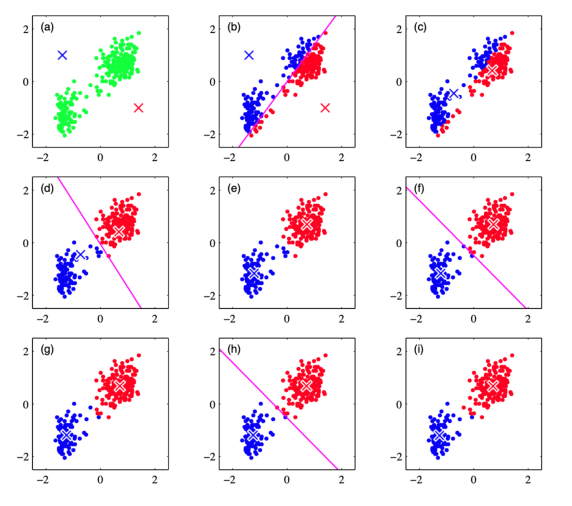

In [2]:
# 图9.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.1.png')
plt.axis('off')
ax.imshow(d)


 
图 9.1 使用重新缩放的老忠实间歇喷泉数据集对K均值算法进行说明。(a)绿点表示二维欧几里得空间中的数据集，中心$ \mu_1, \mu_2 $的初始选择分别用红色叉号和蓝色叉号表示。(b)在初始的E步骤中，每个数据点被分配为红色聚类或者蓝色聚类，根据与哪个中心更近来确定类别。这等价于根据两个聚类中心的垂直平分线来对数据点进行分类，中垂线用洋红色直线表示。(c)在接下来的M步骤中，每个聚类中心使用分 配到对应类别的数据点重新计算。(d)-(i)给出了接下来的E步骤和M步骤，直到最终收敛。

对于这个例子，我们对数据进行了一个线性的被称为标准化(standardizing)的重新标度，使得每个变量的均值为0，标准差为单位标准差。这个例子中，我们选择了$ K = 2 $，因此这种情况下，将每个数据点分配到最近的聚类中心等价于将数据点按照其位于两个数据中心的垂直平分线的哪一侧对数据点进行分类。对于忠老泉数据，式（9.1）给出的代价函数如图9.2所示。
 

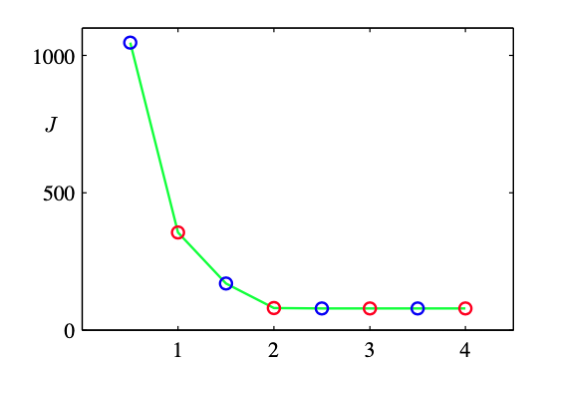

In [4]:
# 图9.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.2.png')
plt.axis('off')
ax.imshow(d)

图 9.2 对于图9.1给出的K均值算法，在每个E步骤（蓝点）和M步骤（红点）之后，代价函数$ J $的图像。 算法在第三个M步骤之后收敛，最后一个EM循环对于分类情况和代表向量都没造成改变。

注意，我们故意将聚类中心选择了较差的初始值，从而算法在收敛之前执行了若干步。在实际应用中，一个更好的初始化步骤是将聚类中心选择为由$ K $个随机数据点组成的子集。还有一点值得注意的地方，K均值算法本身经常被用于在EM算法之前初始化高斯混合模型的参数。

直接实现这里讨论的K均值算法会相当慢，因为在每个E步骤中，必须计算每个代表向量与每个数据点之间的欧几里得距离。关于加速K均值算法，有很多方法被提出来，一些方法基于对数据结构的预先计算，如将数据组织成树结构，使得相邻的数据点属于同一个子树（Ramasubramanian and Paliwal, 1990; Moore, 2000）。另外一些方法使用距离的三角不等式，因此避免了不必要的距离计算（Hodgson, 1998; Elkan, 2003）。

目前为止，我们已经研究了K均值算法的一个批处理版本，其中每次更新代表向量时都使用了整个数据集。我们也可以推导一个在线随机算法（MacQueen, 1967），方法是：将Robbins-Monro步骤应用到寻找回归函数的根的问题中，其中回归函数由式（9.1）给出的$ J $关于$ \mu_k $的导数给出。这产生了顺序更新算法，其中对于每个数据点$ x_n $，我们使用下式更新最近的代表向量$ \mu_k $。
$ \mu_k^{new} = \mu_k^{old} + \eta_n(x_n + \mu_k^{old}) \tag{9.5}
$
其中$ \eta_n $是学习率参数，通常令其关于数据点的数量单调递减。

K均值算法的基础是将平方欧几里得距离作为数据点与代表向量之间不相似程度的度量。这不仅限制了能够处理的数据变量的类型（如它不能处理某些或全部变量表示类别标签的情形），而且使得聚类中心的确定对于异常点不具有健壮性。我们可以这样推广K均值算法：引入两个向量$ x,x' $之间的一个更加一般的不相似程度的度量$ V(x, x') $，然后最小化形式为
$ \tilde{J} = \sum\limits_{n=1}^N\sum\limits_{k=1}^Kr_{nk}V(x_n,\mu_k) \tag{9.6} $
的失真度量。这就给出了K中心点算法（K-medoids algorithm）。与之前一样，对于给定的聚类代表$ mu_k $，E步骤涉及到为每个数据点分配聚类，使得与对应的聚类代表的不相似程度最小。这一步的计算代价为$ O(KN) $，与标准的K均值算法的情形相同。对于不相似程度度量的一般选择，M步骤通常比K均值的情形更加复杂，因此通常会将聚类原型限制为等于某个分配到那个聚类的数据向量，因为这使得算法可以适用于任何不相似程度的度量$ V(\dot,\dot) $，只要它能够被计算。因此，对于每个聚类$ k $，M步骤涉及到在分配到那个聚类的$ N_k $个点上的离散搜索，这需要$ O(N_k^2) $次对$ V(\dot,\dot) $的计算。

K均值算法的一个值得注意的特征是，在每一次迭代中，每个数据点被分配到一个唯一的聚类中。虽然某些数据点与某个特定的中心$ mu_k $的距离远远小于与其他中心的距离，但是也存在其他的数据点，位于两个聚类中心的大概中间的位置。在后一种情形中，强行将数据点分配到最近的聚类不是最合适的。我们在下一节会看到，通过使用概率的方法，我们得到了对数据点聚类的“软”分配，它反映了在最合适聚类分配上的不确定性。这个概率形式带来了一些数值计算上的优势。



In [3]:
# training data
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

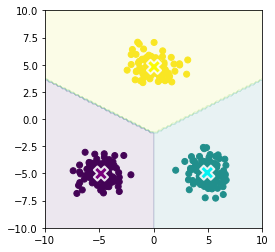

In [4]:
# example
kmeans = KMeans(n_clusters=3)
kmeans.fit(x_train)
cluster = kmeans.predict(x_train)
plt.scatter(x_train[:, 0], x_train[:, 1], c=cluster)
plt.scatter(kmeans.centers[:, 0], kmeans.centers[:, 1], s=200, marker='X', lw=2, c=['purple', 'cyan', 'yellow'], edgecolor="white")
plt.contourf(x0, x1, kmeans.predict(x).reshape(100, 100), alpha=0.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 9.1.1 图像分割与压缩

作为K均值算法的一个应用，我们考虑两个相关的问题，即图像分割和图像压缩。图像分割的目标是将图像分割成若干的区域，每个区域有一个相对相似的视觉外观，或对应于某个物体或物体的一部分（Forsyth and Ponce, 2003）。图像中的每个像素是一个$ 3 $维空间中的一个点， 这个三维空间由红、绿、蓝通道的亮度值构成。我们的分割算法简单地将图像中的每个像素看做一个独立的数据点。注意，严格地说，这个空间不是欧几里得空间,因为通道亮度被限制在区间$ [0, 1] $。尽管这样，我们可以没有难度地应用K均值算法。我们给出了运行K均值算法直至 收敛的结果。对于任意特定的$ K $值，我们将每个像素的$ {R, G, B} $亮度三元组用聚类中心$ \mu_k $的亮度值替代。对于不同的$ K $值,结果如图9.3所示。

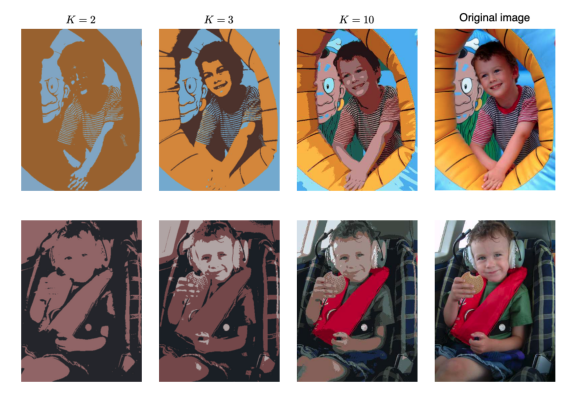

In [5]:
# 图9.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.3.png')
plt.axis('off')
ax.imshow(d)

图 9.3 使用K均值聚类算法进行图像分割的两个例子。图中给出了原始图像以及使用不同的$ K $值得到的K均值分割结果。这张图也说明了向量量子化用于数据压缩的效果，其中较小的$ K $值会得到较高的压缩率，代价是图像的质量更差。

我们看到，对于给定的K值，算法使用一个只有K个颜色的调色板来表示图像。要强调的一点是，K均值的使用对于图像分割来说不是一个 特别复杂的方法，因为它没有考虑不同像素的空间上的近似性。图像分割问题通常特别困难， 仍然是一个活跃的研究领域。在这里进行介绍只是为了说明K 均值算法的行为。
我们也可以使用聚类算法的结果进行数据压缩。区分无损数据压缩（lossless data compression）与有损数据压缩（lossy data compression）是很有必要的。无损数据压缩中，我们的目标是能够从压缩的表示中精确地重建原始数据，而有损数据压缩中，我们接受重建过程中出现的一些错误。我们可以将K均值算法按照下面的方式应用到有损数据压缩中。对于N个数据点中的每一个，我们只存储它被分配的聚类种类k。我们还存储了K个聚类中心μk的值，这通常需要存储小得多的数据,其中我们假定K ≪ N。这样，每个数据点都根据它最近的中心μk确定。新的数据点可以类似地压缩。首先找到最近的μk，然后存储标签k而不是原始的数据向量。这个框架被称为向量量子化(vector quantization)，向量μk被称为编码书向量 (code-book vector)。

上面讨论的图像分割问题也说明了数据压缩中聚类的使用。假设原始图像有N 个像素，每个像素由$ {R, G, B} $三个值组成，每个值由$ 8 $比特的精度存储。这样，直接传递整幅图像需要$ 24N $比特。现在假设我们首先在图像数据上运行K均值算法，然后，我们不直接传递原始像素亮度向量，而是传递最近的向量$ \mu_k $的亮度。由于有$ K $个这样的向量，因此每个像素需要$ \log_2K $比特。我们还必须传送$ K $个编码书向量$ \mu_k $，这需要$ 24K $比特，因此传递这个图像所需的比特总数为$ 24K + N \log_2K $（四舍五入到最近的整数）。图9.3给出的原始图像有$ 240 \times 180 = 43,200 $个像素，因此直接传递需要$ 24 \times 43,200 = 1,036,800 $个比特。作为对比，传递压缩的图像分别需要$ 43,248 $比特（K = 2），$ 86,472 $比特（K = 3）以及$ 173,040 $比特（K = 10）。这表示与原始图像相比，压缩率分别为$ 4.2%, 8.3% $和$ 16.7% $。我们看到存在一个压缩程度与图像质量之间的折中。注意，在这个例子中，我们的目的是说明K均值算法。如果我们的目标是生成一个好的 图像压缩算法，那么更好的方法是考虑相邻像素组成的小块，例如$ 5 \times 5 $，从而利用了自然图像中相邻像素之间存在的相关性。



# 9.2 混合高斯

在2.3.9节，我们将高斯混合模型看成高斯分量的简单线性叠加，目标是提供一类比单独的高斯分布更强大的概率模型。我们现在使用离散潜在变量来描述高斯混合模型。这会让我们更深刻地认识这个重要的分布，也会让我们开始了解期望最大化算法。

回忆一下，根据式（2.188），高斯混合概率分布可以写成高斯分布的线性叠加的形式，即
$ p(x) = \sum\limits_{k=1}^K\pi_k\mathcal{N}(x|\mu_k,\Sigma_k) \tag{9.7} $
让我们引入一个$ K $为二值随机变量$ z $，这个变量采用了“1-of-K”表示方法，其中一个特定的元素$ z_k $等于1，其余所有的元素等于。于是$ z_k $的值满足$ z_k \in {0, 1} $且$ \Sigma_kz_k = 1 $，并且我们看到根据哪个元素非零，向量$ z $有$ K $个可能的状态。我们根据边缘概率分布$ p(z) $和条件概率分布$ p(x|z) $定义联合概率分布$ p(x, z) $，对应于图9.4所示的图模型。
 


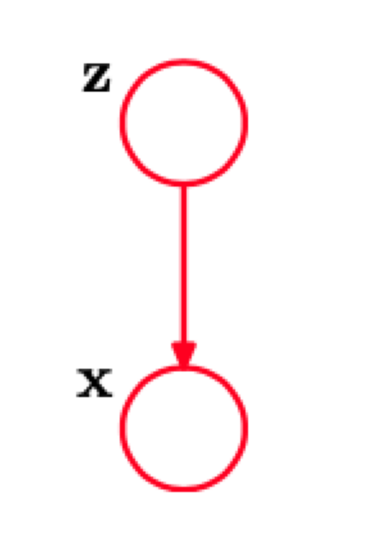

In [6]:
# 图9.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.4.png')
plt.axis('off')
ax.imshow(d)

图 9.4 混合模型的图形表示，其中联合概率分布被表示为$ p(x,z) = p(z)p(x|z) $的形式。

$ z $的边缘概率分布根据混合系数$ \pi_k $进行赋值，即
$ p(z_k = 1) = \pi_k $
其中参数$ {\pi_k} $必须满足
$ 0 \leq \pi_k \leq 1 \tag{9.8} $
以及
$ \sum\limits_{k=1}^K\pi_k = 1 \tag{9.9} $
使得概率是一个合法的值。由于$ z $使用了“1-of-K”表示方法，因此我们也可以将这个概率分布写成
$ p(z) = \prod\limits_{k=1}^K \pi_k^{z_k} \tag{9.10} $
类似地，给定$ z $的一个特定的值，$ x $的条件概率分布是一个高斯分布
$ p(x|z_k = 1) = \mathcal{N}(x|\mu_k,\Sigma_k) $
也可以写成
$ p(x|z) = \prod\limits_{k=1}^K\mathcal{N}(x|\mu_k,\Sigma_k)^{z_k} \tag{9.11} $
联合概率分布为$ p(z)p(x|z) $，从而$ x $的边缘概率分布可以通过将联合概率分布对所有可能的$ z $求和的方式得到，即
$ p(x) = \sum\limits_zp(z)p(x|z) = \sum\limits_{k=1}^K\pi_k\mathcal{N}(x|\mu_k,\Sigma_k) \tag{9.12} $
其中我们使用了式（9.10）和式（9.11）。因此$ x $的边缘分布是式（9.7）的高斯混合分布。如果我们有若干个观测$ x_1,...,x_N $，那么，由于我们已经用$ p(x) = \sum_z p(x, z) $的方式表示了边缘概率分布，因此对于每个观测数据点$ x_n $，存在一个对应的潜在变量$ z_n $。
于是，我们找到了高斯混合分布的一个等价的公式，将潜在变量显式地写出。似乎我们这么做没有什么意义。但是，我们现在能够对联合概率分布$ p(x,z) $操作，而不是对边缘分布$ p(x) $操作，这会产生极大的计算上的简化。通过引入期望最大化（EM）算法，即可看到这一点。
另一个起着重要作用的量是给定$ x $的条件下，$ z $的条件概率。我们会用$ \gamma(z_k) $表示$ p(z_k=1|x) $，它的值可以使用贝叶斯定理求出
$ \begin{eqnarray} \gamma(z_k) \equiv p(z_k = 1|x) &=& \frac{p(z_k = 1)p(x|z_k = 1)}{\sum\limits_{j=1}^Kp(z_j=1)p(x|z_j = 1)} \ &=& \frac{\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)}{\sum\limits_{j=1}^K\pi_j\mathcal{N}(x|\mu_j,\Sigma_k)} \tag{9.13} \end{eqnarray} $
我们将$ \pi_k $看成$ z_k = 1 $的先验概率，将$ \gamma(z_k) $看成观测到$ x $之后，对应的后验概率。正如我们将看到的那样，$ \gamma(z_k) $也可以被看做分量$ k $对于“解释”观测值x的“责任”（responsibility）。
我们可以使用祖先取样的方法生成服从高斯混合模型的概率分布的随机样本。为了完成这件事，我们首先生成$ z $的一个值，记作$ \hat{z} $，它服从概率分布$ p(z) $。然后，根据条件概率分布$ p(x|\hat{z}) $生成$ x $的一个值。从标准的概率分布中取样的方法将在第11章讨论。我们可以用下面的方法描绘联合概率分布$ p(x,z) $：首先画出$ x $的对应值的点，然后根据$ z $的值对它进行着色，换句话说，根据哪个高斯分布负责生成这个数据进行着色，如图9.5(a)所示。
 

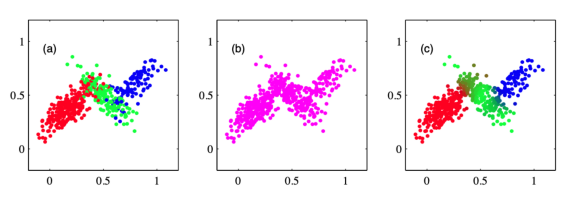

In [7]:
# 图9.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.5.png')
plt.axis('off')
ax.imshow(d)


图 9.5 从图2.23给出的3个高斯分布组成的混合分布中抽取的500个样本点。(a)从联合概率分布$ p(z)p(x|z) $中抽取的样本，其中$ z $的三种状态对应于混合分布的三个分量，用红色、绿色、蓝色表示。(b)来自边缘概率分布$ p(x) $的对应的样本，仅仅将z的值忽略，画出$ x $的值即可。(a)中的数据集被称为 完整的,(b)中的数据集被称为不完整的。(c)同样的样本，颜色表示与数据点$ x_n $关联的责任$ \gamma(z_{nk}) $，其中红色、蓝色、绿色所占的比重分别由$ \gamma(z_{nk}), k = 1,2,3 $给出。

类似地，服从边缘概率分布$ p(x) $的样本可以通过从联合概率分布中取样然后忽略z的值的方式得到。这些如图9.5(b) 所示。图中画出了$ x $的值，没有任何颜色标记。

我们也可以使用这个人工生成的数据来说明“责任”的含义。对于每个数据点，我们计算生成了数据集的混合概率分布的每个分量的后验概率分布。特别地，我们可以表示出与数据点xn相关联的责任$ \gamma(z_{nk}) $的值，方法是：对于$ k = 1, 2, 3 $，我们分别用红色、蓝色、绿色来画出对应的点，点的颜色的红蓝绿分量的比例由$ \gamma(z_{nk}) $给出，如图9.5(c)所示。因此，$ γ(z_{n1}) = 1 $的数据点会被标记为红色，而$ \gamma(z_{n2}) = \gamma(z_{n3}) = 0.5 $的数据点的颜色中，蓝色和绿色的比例相同，因此是青色。应该将这幅图与图9.5(a)进行对比，那里数据点使用它们被生成的真实的分量类别进行了标记。




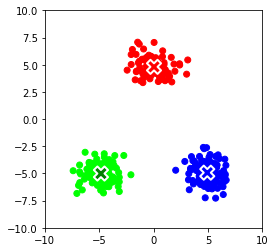

In [5]:
# plot
gmm = MultivariateGaussianMixture(n_components=3)
gmm.fit(x_train)
p = gmm.classify_proba(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=p)
plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()

## 9.2.1 最大似然

假设我们有一个观测的数据集$ {x_1,...,x_N} $，我们希望使用混合高斯模型来对数据进行建模。我们可以将这个数据集表示为一个$ N \times D $的矩阵$ X $，其中第$ n $行为$ x_n^T $。类似地，对应的隐含变量会被表示为一个$ N \times K $的矩阵$ Z $，它的行由$ z_n^T $给出。如果我们假定数据点独立地从概率分布中抽取，那么我们可以使用图9.6所示的图模型来表示这个独立同分布数据集的高斯混合模型。
 

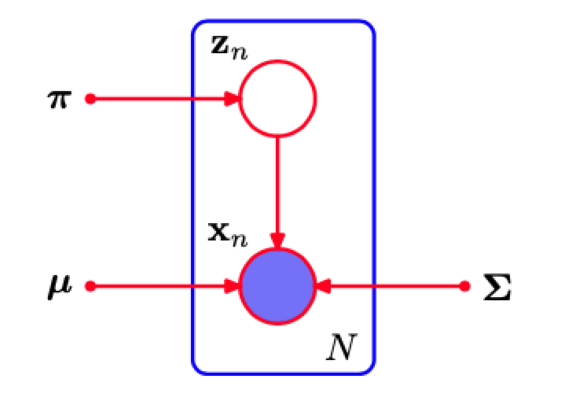

In [8]:
# 图9.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.6.png')
plt.axis('off')
ax.imshow(d)

图 9.6 一组$ N $个独立同分布数据点$ {x_n} $的高斯混合模型的图表示，对应的潜在变量为$ {z_n} $，其中$ n = 1,...,N $。

根据式（9.7），对数似然函数为
$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)\right\}
\tag{9.14} $$

在我们讨论如何最大化这个函数之前，有必要强调一下由于奇异性的存在造成的应用于高斯混合模型的最大似然框架中的一个大问题。为了简化起见，我们考虑一个高斯混合模型，它的分量的协方差矩阵为$ \Sigma_k = \sigma_k^2I $，其中$ I $是一个单位矩阵，结论对于一般的协方差矩阵仍然成立。假设混合模型的第$ j $个分量的均值$ \mu_j $与某个数据点完全相同，即对于某个$ n $值，$ \mu_j = x_n $。这样，这个数据点会为似然函数贡献一项，形式为

$ \mathcal{N}(x_n|x_n,\sigma_j^2I) = \frac{1}{(2\pi)^{1/2}}\frac{1}{\sigma_j^D} \tag{9.15} $

如果我们考虑极限$ \sigma_j \to 0 $，那么我们看到这一项趋于无穷大，因此对数似然函数也会趋于无穷大。因此，对数似然函数的最大化不是一个具有良好定义的问题，因为这种奇异性总会出现，会发生在任何一个“退化”到一个具体的数据点上的高斯分量上。回忆一下，这个问题在单一的高斯分布中没有出现。为了理解不同之处，我们注意到，如果单一的高斯分布退化到了一个数据点上，那么它总会给由其他数据点产生的似然函数贡献可乘的因子，这些因子会以指数的速度趋于0，从而使得整体的似然函数趋于零而不是无穷大。然而，一旦我们在混合概率分布中存在（至少）两个分量，其中一个分量会具有有限的方差，因此对所有的数据点都会赋予一个有限的概率值，而另一个分量会收缩到一个具体的数据点，因此会给对数似然函数贡献一个不断增加的值。如图9.7所示。

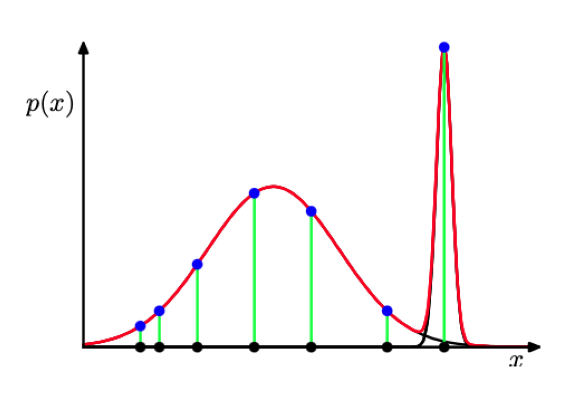

In [9]:
# 图9.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.7.png')
plt.axis('off')
ax.imshow(d)

图 9.7 似然函数的奇异性在混合高斯模型中如何出现的说明。应该将这幅图与图1.14展示的单变量高斯分布的情形进行对比，那里没有产生奇异性。

这种奇异性提供了最大似然方法中出现的过拟合现象的另一个例子。我们后面会看到，如果我们使用贝叶斯方法，那么这种困难之处就不会出现。但是现阶段，我们只需注意，将最大似然方法应用到高斯混合模型中时必须避免这种病态解，并且寻找表现较好的似然函数的局部极大值。我们可以使用合适的启发式方法来避免这种奇异性，例如：如果检测到高斯分量收缩到一个点，那么就将它的均值重新设定为一个随机选择的值，并且重新将它的方差设置为某个较大的值，然后继续最优化。

寻找最大似然解时的另一个问题产生于下面的事实：对于任意给定的最大似然解，一个由$ K $个分量混合而成的概率分布总共会有$ K! $个等价的解，对应于$ K! $种将$ K $个参数集合分配到$ K $个分量上的方式。换句话说，对于参数值空间中任意给定的点，都会有$ K! − 1 $个其他的点给出完全相同的概率分布。这个问题被称为可区分（identifiability）问题（Casella and Berger, 2002），当我们希望表示模型的参数时，这是一个重要的问题。当我们在第12章讨论具有连续潜在变量的模型时，可区分问题还会出现。但是，这个问题与找到一个好的概率模型无关，因为任意等价的解互相之间都一样好。

最大化高斯混合模型的对数似然函数（9.14）比单一的高斯分布的情形更加复杂。困难来源于在式（9.14）中，对$ k $的求和出现在对数计算内部，从而对数函数不再直接作用于高斯分布。如果我们令对数似然函数的导数等于零，那么我们不会得到一个解析解，正如我们将看到的那样。
一种方法是使用基于梯度的优化方法（Fletcher, 1987; Nocedal and Wright, 1999; Bishop and Nabney, 2008）。虽然基于梯度的方法是可行的，并且当我们在第5章中讨论混合密度网络时起了重要的作用，但是我们现在考虑另一种方法，被称为EM算法。它具有广泛的适用性，是我们将在第10章讨论的变分推断的基础。

参考资料：https://www.slideshare.net/tamurashinichi/prml-49407244

## 9.2.2 用于高斯混合模型的EM

一种优雅的并且强大的寻找带有潜在变量的模型的最大似然解的方法被称为期望最大化算法（expectation-maximization algorithm），或EM算法（Dempster et al., 1977; McLachlan and Krishnan, 1997）。稍后，我们会给出EM算法的一般形式，并且我们也会给出如何推广EM得到变分推断的框架。但是现在，我们会在高斯混合模型的问题中，给出EM算法的一种相对非形式化的描述。然而，我们要强调的是，EM算法具有广泛的适用性，实际上在本书中讨论的许多不同模型中都会遇到它。


$$ \mathcal{N}(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}} exp\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x - \mu)\} \tag{2.43} $$

首先，让我们写下似然函数的最大值必须满足的条件。令式（9.14）中$ \ln p(X|\pi, \mu, \Sigma) $关于高斯分量的均值$ \mu_k $的微分等于0，我们有

$$
0=\sum_{n=1}^{N} \underbrace{\frac{\pi_{k} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)}{\sum_{j} \pi_{j} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{j}, \boldsymbol{\Sigma}_{j}\right)}}_{\gamma\left(z_{n k}\right)} \boldsymbol{\Sigma}_{k}^{-1}\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right)
 \tag{9.16} $$


其中我们使用了高斯分布的式（2.43）。注意，式（9.13）给出的后验概率（或称为“责任”）很自然地出现在了等式右侧。两侧同时乘以$ \Sigma_k $（假设矩阵是非奇异的），整理，可得
$ \mu_k = \frac{1}{N_k}\sum\limits_{n=1}^N\gamma(z_{nk})x_n \tag{9.17} $
其中我们定义了
$ N_k = \sum\limits_{n=1}^N\gamma(z_{nk}) \tag{9.18} $
我们可以将$ N_k $看做分配到聚类$ k $的数据点的有效数量。仔细研究这个解的形式。我们看到第$ k $个高斯分量的均值$ \mu_k $通过对数据集里所有的数据点求加权平均的方式得到，其中数据点$ x_n $的权因子由后验概率$ \gamma(z_{nk}) $给出，而$ \gamma(z_{nk}) $表示分量$ k $对生成$ x_n $的责任。
如果我们令$ \ln p(X | \pi, \mu, \Sigma) $关于$ \Sigma_k $的导数等于0，然后用一个类似的推理过程，使用单一高斯分布协方差矩阵的最大似然结果，我们有
$ \Sigma_k = \frac{1}{N_k}\sum\limits_{n=1}^N\gamma(z_{nk})(x_n - \mu_k)(x - \mu_k)^T \tag{9.19} $
这与一元高斯分布的对应的结果具有相同的函数形式，但是与之前一样，每个数据点都有一个权值，权值等于对应的后验概率，分母为与对应分量相关联的数据点的有效数量。
最后，我们关于混合系数$ \pi_k $最大化$ \ln p(X | \pi, \mu, \Sigma) $。这里我们必须考虑限制条件（9.9），它要求混合系数的总和等于1。使用拉格朗日乘数法，最大化下面的量
$ \ln p(X|\pi,\mu,\Sigma) + \lambda\left(\sum\limits_{k=1}^K\pi_k - 1\right) \tag{9.20} $
得到
$ 0 = \sum\limits_{n=1}^N\frac{\mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum_j\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j} + \lambda \tag{9.21} $
其中，我们再次看到“责任”这一项。如果我们将两边乘以$ \pi_k $，然是使用式（9.9）对$ k $求和，我们会发现$ \lambda = -N $。使用这个结果消去$ \lambda $，整理，可得
$ \pi_k = \frac{N_k}{N} \tag{9.22} $
从而第$ k $个分量的混合系数为那个分量对于解释数据点的“责任”的平均值。


值得强调的时，结果（9.17）、（9.19）和（9.22）并没有给出混合模型参数的一个解析解，因为“责任”$ \gamma(z_{nk}) $ 通过公式（9.13）以一种复杂的方式依赖于这些参数。然而，这些结果确实给出了一个简单的迭代方法来寻找问题的最大似然解。正如我们将看到的那样，这个迭代过程是EM算法应用于高斯混合模型的一个实例。我们首先为均值、协方差、混合系数选择一个初始值。然后，我们交替进行两个更新，被称为E步骤和M步骤，原因稍后会看到。在期望步骤（expectation step）或者E步骤中，我们使用参数的当前值计算公式（9.13）给出的后验概率（也被称为“责任”）。然后，我们将计算出的概率用于最大化步骤（maximization step）或者M步骤中，使用公式（9.17）、（9.19）和（9.22）重新估计均值、方差和混合系数。注意， 在进行这一步骤时，我们首先使用公式（9.17）计算新的均值，然后使用新的均值通过公式 （9.19）找到协方差，这与单一高斯分布的对应结果保持一致。我们稍后会证明，每次通过E步骤和接下来的M步骤对参数的更新确保了对数似然函数的增大。在实际应用中，当对数似然函数的变化量或者参数的变化量低于某个阈值时，我们就认为算法收敛。图9.8给出了将两个高斯分布组成的混合概率分布的EM算法应用于老忠实间歇喷泉数据集的情形。

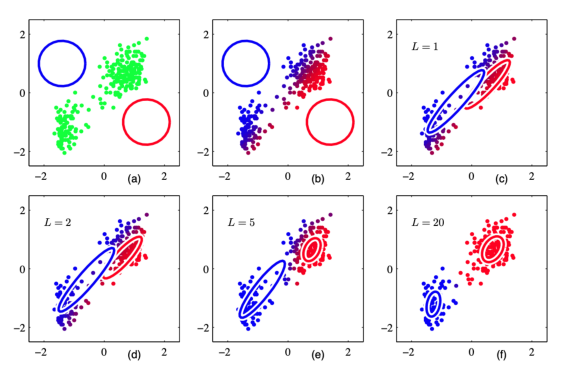

In [10]:
# 图9.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.8.png')
plt.axis('off')
ax.imshow(d)


 
图 9.8 对忠老泉数据集使用EM算法的说明，这个数据集在图9.1中用来说明K均值算法。

这里，我们使用了两 个高斯分布的混合，分布中心的初始值与图9.1中的K均值算法使用了相同的初始值，精度矩阵被初始化为正比于单位矩阵。图(a)用绿色标记出了数据点，以及初始的混合模型的配置，其中两个高斯分量的一个标准差位置的轮廓线分别用红色圆圈和蓝色圆圈标记。图(b)给出了初始E步骤的结果，其中每个数据点的颜色中，蓝色所占的比重等于由蓝色分量生成对应数据点的后验概率，红色所占的比重等于由红色分量生成对应数据点的后验概率。因此，对于属于两个聚类的后验概率都较大的数据点来说，颜色看起来是紫色的。图(c)给出了第一个M步骤之后的结果，其中蓝色高斯分布的均值被移至数据点的均值，同时根据属于蓝色类别的每个数据点的概率进行加权。换句话说，它被移到了蓝色标记数据点的质心。类似地，蓝色高斯分布的协方差被设置为蓝色标记数据点的协方差。红色分量的情形与此类似。图(d)，(e)和(f)分别给出了2次、5次、20次完整的EM循环之后的结果。在图(f)中，算法接近收敛。

注意，与K均值算法相比，EM算法在达到（近似）收敛之前，经历了更多次的迭代，每次迭代需要更多的计算量。因此，通常运行K均值算法找到高斯混合模型的一个合适的初始化值，接下来使用EM算法进行调节。协方差矩阵可以很方便地初始化为通过K均值算法找到的聚类的样本协方差，混合系数可以被设置为分配到对应类别中的数据点所占的比例。与最大化对数似然函数的基于梯度的方法相同，算法必须避免似然函数带来的奇异性，即高斯分量退化到一个具体的数据点。应该强调的是，通常对数似然函数会有多个局部极大值，EM不保证找到这些极大值中最大的一个。由于高斯混合模型的EM算法非常重要，因此我们总结如下。


给定一个高斯混合模型，目标是关于参数（均值、协方差、混合系数）最大化似然函数。
1.	初始化均值$ \mu_k $、协方差$ \Sigma_k $和混合系数$ \pi_k $，计算对数似然函数的初始值。
2.	E步骤。使用当前参数值计算“责任”。
$ \gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum\limits_{j=1}^K\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)} \tag{9.23} $
3.	M步骤。使用当前的“责任”重新估计参数。
$ \begin{eqnarray} \mu_k^{new} &=& \frac{1}{N_k}\sum\limits_{n=1}^N\gamma(z_{nk})x_n \tag{9.24} \\ \Sigma_k^{new} &=& \frac{1}{N_k}\sum\limits_{n=1}^N\gamma(z_{nk})(x_n - \mu_k^{new})(x_n - \mu_k^{new})^T \tag{9.25} \\ \pi_k^{new} &=& \frac{N_k}{N} \tag{9.26} \end{eqnarray} $
其中
$ N_k = \sum\limits_{n=1}^N\gamma(z_{nk}) \tag{9.27} $
4.	计算对数似然函数
$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)\right\}
\tag{9.28} $$
检查参数或者对数似然函数的收敛性。如果没有满足收敛的准则，则返回第2步。




# 9.3 EM的另一种观点

本节中,我们介绍EM算法的另一种观点，其中潜在变量起着重要的作用。我们首先使用一种抽象的方式讨论这种方法，然后我们再次考虑高斯混合模型的例子，来具体说明这个模型。

EM算法的目标是找到具有潜在变量的模型的最大似然解。我们将所有观测数据的集合记作$ X $，其中第$ n $行表示$ x_n^T $。类似地，我们将所有潜在变量的集合记作$ Z $，对应的行为$ z_n^T $。所有模型参数的集合被记作$ \theta $，因此对数似然函数为
$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\theta})=\ln \left\{\sum_{\boldsymbol{Z}} p(\boldsymbol{X}, \boldsymbol{Z} \mid \boldsymbol{\theta})\right\}
\tag{9.29} $$
注意，这同样适用于连续潜在变量的情形，只需把对$ Z $的求和替换为积分即可。

一个关键的现象是，对于潜在变量的求和位于对数的内部。即使联合概率分布$ p(X,Z|\theta) $属于指数族分布，由于这个求和式的存在，边缘概率分布$ p(X|\theta) $通常也不是指数族分布。求和式的出现阻止了对数运算直接作用于联合概率分布，使得最大似然解的形式更加复杂。



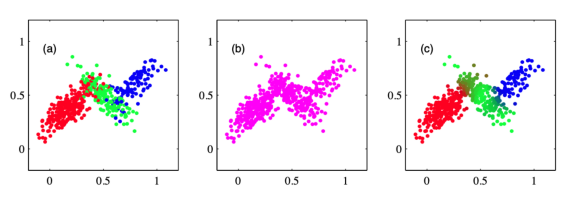

In [13]:
# 图9.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.5.png')
plt.axis('off')
ax.imshow(d)

现在假定对于$ X $中的每个观测，我们都有潜在变量$ Z $的对应值。我们将$ {X, Z} $称为完整（complete）数据集，并且我们称实际的观测数据集X是不完整的（incomplete），如图9.5所示。完整数据集的对数似然函数的形式为$ \ln p(X, Z|\theta) $，并且我们假定对这个完整数据的对数似然函数进行最大化是很容易的。

然而，在实际应用中，我们没有完整数据集$ {X, Z} $，只有不完整的数据$ X $。我们关于潜在变量$ Z $的取值的知识仅仅来源于后验概率分布$ p(Z|X, \theta) $。由于我们不能使用完整数据的对数似然函数，因此我们反过来考虑在潜在变量的后验概率分布下，它的期望值，这对应于EM算法中的E步骤（稍后会看到）。在接下来的M步骤中，我们最大化这个期望。如果当前对于参数的估计为$ \theta^{old} $，那么一次连续的E步骤和M步骤会产生一个修正的估计$ \theta^{new} $。算法在初始化时选择了 参数$ \theta_0 $的某个起始值。对期望的使用看起来多少有些随意，但是当我们在9.4节更深入地讨论EM算法时，我们会看到这种选择的原因。

在E步骤中，我们使用当前的参数值$ \theta^{old} $寻找潜在变量的后验概率分布$ p(Z|X, \theta^{old} ) $。然后，我们使用这个后验概率分布计算完整数据对数似然函数对于一般的参数值$ \theta $的期望。这个期望被记作$ Q(\theta, \theta^{old}) $，由
$ Q(\theta, \theta^{old}) = \sum\limits_Zp(Z|X,\theta^{old})\ln p(X,Z|\theta) \tag{9.30} $
给出。在M步骤中，我们通过最大化
$ \theta^{new} = \arg\max Q(\theta, \theta^{old}) \tag{9.31} $
来确定修正后的参数估计$ \theta^{new} $。注意，在$ Q(\theta, \theta^{old}) $的定义中，对数操作直接作用于联合概率分布$ p(X,Z|\theta) $，因此根据假设，对应的M步骤的最大化是可以计算的。


一般的EM算法总结如下。正如我们稍后会看到的那样，每个EM循环都会增大不完整数据的对数似然函数（除非已经达到局部极大值）。
###一般的EM算法
给定观测变量$ X $和潜在变量$ Z $上的一个联合概率分布$ p(X,Z|\theta) $，由参数$ \theta $控制，目标是关于$ \theta $最大化似然函数$ p(X|\theta) $。
1.	选择参数$ \theta^{old} $的一个初始设置。
2.	E步骤。计算$ p(Z|X,\theta^{old}) $。
3.	M步骤。计算$ \theta^{new} $，由 $ \theta^{new} = \arg\max_{\theta} Q(\theta, \theta^{old}) \tag{9.32} $ 给出。其中 $ Q(\theta, \theta^{old}) = \sum\limits_Zp(Z|X,\theta^{old})\ln p(X,Z|\theta) \tag{9.33} $
4.	检查对数似然函数或者参数值的收敛性。如果不满足收敛准则，那么令 $ \theta^{old} = \theta^{new} \tag{9.34} $ 然后回到第2步。


EM算法也可以用来寻找模型的MAP（最大后验概率）解，此时我们定义一个参数上的先验概率分布$ p(\theta) $。在这种情况下，E步骤与最大似然的情形相同，而在M步骤中，需要最大化的量为$ Q(\theta, \theta^{old}) + \ln p(\theta) $。选择合适的先验概率分布会消除图9.7所示的奇异性。
这里，我们考虑了使用EM算法最大化一个包含离散潜在变量的似然函数。然而，它也适用于未观测的变量对应于数据集里的缺失值的情形。观测值的概率分布可以通过对所有变量的联合概率分布关于缺失变量求和或积分的方式得到。这样，EM算法可以用来最大化对应的似然函数。我们后面在图12.11中讨论主成分分析时，会给出这种方法的一个应用。EM算法也适用于数据集随机缺失（missing at random）的情形，即导致某个值缺失的原因不依赖于未观测的值。这种情形有很多，例如当传感器的测量值超过某个阈值时，传感器就不会成功地返回一个值。



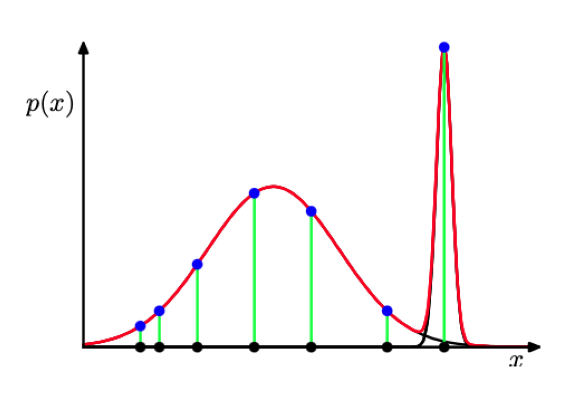

In [12]:
# 图9.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.7.png')
plt.axis('off')
ax.imshow(d)

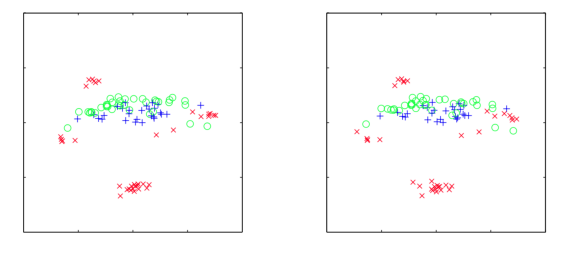

In [11]:
# 图12.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图12.11.png')
plt.axis('off')
ax.imshow(d)

## 9.3.1 重新考虑高斯混合模型

$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)\right\}
\tag{9.14} $$

我们现在考虑将EM算法的潜在变量观点应用与一个具体的例子，即高斯混合模型。回忆一 下，我们的目标是最大化对数似然函数（9.14），它是使用观测数据集$ X $进行计算的。我们看到这个计算比单一高斯分布的情形更困难，因为对$ k $的求和出现在对数运算内部。假设除了观测数据集$ X $，我们还有对应的离散变量$ Z $的值。回忆一下，图9.5(a)给出了一个“完整”的数据集，即给出了每个数据点由哪个分量生成，而图9.5(b)给出了对应的“不完整”数据集。完整数据的图模型如图9.9所示。

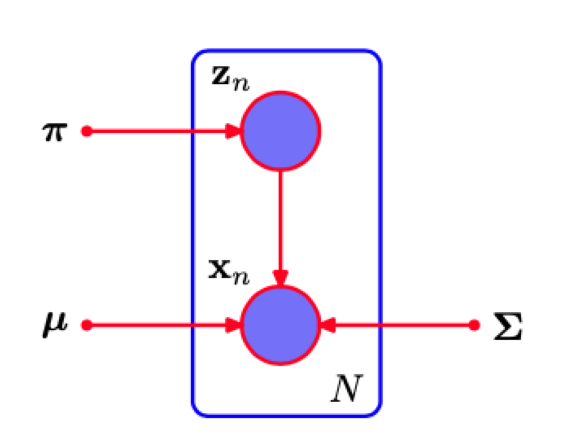

In [14]:
# 图9.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.9.png')
plt.axis('off')
ax.imshow(d)

图 9.9 本图与图9.6相同，只是我们现在假定离散变量$ z_n $以及观测变量$ x_n $被观测到。

$ p(z) = \prod\limits_{k=1}^K \pi_k^{z_k} \tag{9.10} $

$ p(x|z) = \prod\limits_{k=1}^K\mathcal{N}(x|\mu_k,\Sigma_k)^{z_k} \tag{9.11} $

现在考虑对完整数据$ {X, Z} $进行最大化。根据式（9.10）和式（9.11），似然函数的形式为
$ p(X,Z|\mu,\Sigma,\pi) = \prod\limits_{n=1}^N\prod\limits_{k=1}^K\pi_k^{z_{nk}}\mathcal{N}(x_n|\mu_k,\Sigma_k)^{z_{nk}} \tag{9.35} $
其中$ z_{nk} $表示$ z_n $的第$ k $个分量。取对数，得到
$ \ln p(X,Z|\mu,\Sigma,\pi) = \sum\limits_{n=1}^N\sum\limits_{k=1}^Kz_{nk}\{\ln\pi_k + \ln\mathcal{N}(x_n|\mu_k,\Sigma_k)\} \tag{9.36} $

$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)\right\}
\tag{9.14} $$

与不完整数据的对数似然函数（9.14）进行对比，我们看到在$ k $上的求和与对数运算的顺序交换了。对数运算现在直接作用于高斯分布上，而高斯分布本身是指数族分布的一个成员。丝毫不令人惊讶，这种方法产生了最大似然问题的一个简单得多的解，说明如下。首先考虑关于均值和协方差的最大化。由于$ z_n $是一个$ K $维向量，并且只有一个元素等于1，其他所有元素均为0，因此完整数据的对数似然函数仅仅是$ K $个独立的贡献的和，每个混合分量都有一个贡献。于是关于均值或协方差的最大化与单一高斯分布的情形完全相同，唯一的区别是它只涉及到被“分配”到那个分量的数据点的子集。对于关于混合系数的最大化问题，我们注意到由于和限制（9.9）的存在，不同$ k $值的混合系数相互关联。与之前一样，可以使用拉格朗日乘数法进行优化，结果为
$ \pi_k = \frac{1}{N}\sum\limits_{n=1}^Nz_{nk} \tag{9.37} $
从而混合系数等于分配到对应分量的数据点所占的比例。

$ \sum\limits_{k=1}^K\pi_k = 1 \tag{9.9} $


$ p(z) = \prod\limits_{k=1}^K \pi_k^{z_k} \tag{9.10} $

$ p(x|z) = \prod\limits_{k=1}^K\mathcal{N}(x|\mu_k,\Sigma_k)^{z_k} \tag{9.11} $



因此我们看到，完整数据的对数似然函数可以用一种简单的方法求出最大值的解析解。然而，在实际应用中，我们并没有潜在变量的值，因此，与之前的讨论一样，我们考虑完整数据对数似然函数关于潜在变量后验概率分布的期望。使用式（9.10）、（9.11）以及贝叶斯定理，我们看到这个后验分布的形式为
$ p(Z,X,\mu,\Sigma,\pi) \propto \prod\limits_{n=1}^N\prod\limits_{k=1}^K[\pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k)]^{z_{nk}} \tag{9.38} $
因此后验概率分布可以在$ n $上进行分解，从而$ {z_n} $是独立的。通过观察9.6中的有向图然后使用d-划分准则，很容易证明这一点。这样，在这个后验概率分布下，指示值$ z_{nk} $的期望为
$ \begin{eqnarray} \mathbb{E}[z_{nk}] &=& \frac{\sum\limits_{z_n}z_{nk}\prod_{k'}[\pi_{k'}\mathcal{N}(x_n|\mu_{k'},\Sigma_{k'})]^{z_{nk'}}}{\sum\limits_{z_n}\prod_j[\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)]^{z_{nj}}} \ &=& \frac{\pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum\limits_{j=1}^K\pi_j\mathcal{N}(x_n|\mu_j,\Sigma_j)} = \gamma(z_{nk}) \tag{9.39} \end{eqnarray} $
它就是$ k $分量对于数据点$ x_n $的“责任”。于是，完整数据的对数似然函数的期望值为
$ \mathbb{E}_Z[\ln p(X,Z|\mu,\Sigma,\pi)] = \sum\limits_{n=1}^N\sum\limits_{k=1}^K\gamma(z_{nk}){\ln \pi_k + \ln\mathcal{N}(x_n|\mu_k,\Sigma_k)} \tag{9.40} $
我们现在可以按照下面的方式进行处理。首先，我们为参数$ \mu^{old}, \Sigma^{old}, \pi^{old} $选择某个初始值，使用这些初始值计算“责任”(E步骤)。然后我们保持“责任”固定，关于$ \mu_k,\Sigma_k, \pi_k $最大化（9.40）（M步骤）。同样的，这会得到由式（9.17）、（9.19）和（9.22）给出$ \mu^{new}, \Sigma^{new}, \pi^{new} $的解析解。这与之前推导的高斯混合模型的EM算法完全相同。当我们在9.4节证明EM算法的收敛性时，我们会更加深刻地认识到完整数据的对数似然函数的期望的作用。

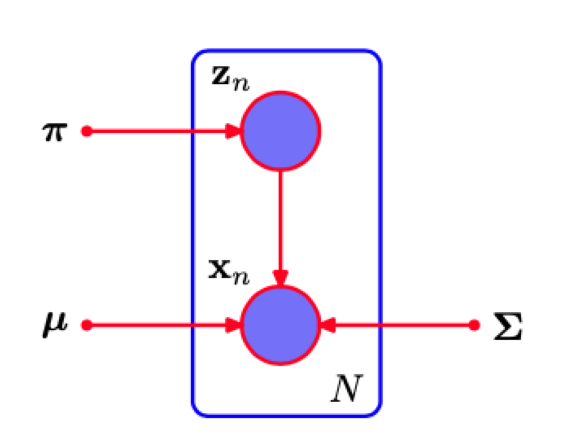

In [3]:
# 图9.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.9.png')
plt.axis('off')
ax.imshow(d)

参考资料：
- https://www.slideshare.net/matsuolab/prml9-78266147
- https://www.slideshare.net/takao-y/20131113-em

## 9.3.2 与K均值的关系

对比高斯模型的EM算法与K均值算法，可以看到二者有很强的相似性。K均值算法对数据点的聚类进行了“硬”分配，即每个数据点只属于唯一的聚类，而EM算法基于后验概率分布，进 行了一个“软”分配。实际上，我们可以将K均值算法看成高斯混合模型的EM算法的一个特殊的极限情况，如下所述：
考虑一个高斯混合模型，其中混合分量的协方差矩阵为$ \epsilon I $， $ \epsilon $是一个被所有分量共享的方差参数，$ I $是单位矩阵，从而
$$
p\left(\boldsymbol{x} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)=\frac{1}{(2 \pi \epsilon)^{\frac{D}{2}}} \exp \left\{-\frac{1}{2 \epsilon}\left\|\boldsymbol{x}-\boldsymbol{\mu}_{k}\right\|^{2}\right\}
 \tag{9.41} $$
我们现在考虑$ K $个这种形式的高斯分布组成的混合模型的EM算法，其中我们将$ \epsilon $看做一个固定的常数，而不是一个需要重新估计的参数。根据式（9.13），对于一个特定的数据点$ x_n $，后验概率（或“责任”）为
$$
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \exp \left\{-\frac{\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right\|^{2}}{2 \epsilon}\right\}}{\sum_{j} \pi_{j} \exp \left\{-\frac{\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{j}\right\|^{2}}{2 \epsilon}\right\}}
\tag{9.42} $$
如果我们考虑极限情况$ \epsilon \to 0 $，那么我们看到，在分母中，$ \Vert x_n − \mu_j\Vert^2 $最小的项将会最慢地趋近于0，因此对于数据点$ x_n $，只有项j的“责任”$ \gamma(z_{nj}) $趋近于1，其他的项的“责任””$ \gamma(z_{nj}) $都趋近于0。因此，在这种极限情况下，我们得到了对数据点聚类的一个硬分配，与K-均值算法相同，从而”$ \gamma(z_{nj}) \to r_{nk} $，其中$ r_{nk} $由式（9.2）定义。因此，每个数据点都被分配为距离最近的均值的聚类。

这样，式（9.17）给出的$ \mu_k $的EM重估计就简化为了K均值的结果（9.4）。注意，混合系数（9.22）的重估计公式仅仅将$ \pi_k $的值重新设置为等于分配到聚类k中的数据点的比例，虽然这些参数在算法中不再起作用。

最后，在极限$ \epsilon \to 0 $的情况下，式（9.40）给出的完整数据的对数似然函数变成了
$ \mathcal{E}Z[\ln p(X,Z|\mu,\Sigma,\pi)] \to -\frac{1}{2}\sum\limits{n=1}^N\sum\limits_{k=1}^Kr_{nk}\Vert x_n - \mu_k \Vert^2 + const \tag{9.43} $
因此在极限的情况下，最大化完整数据对数似然函数的期望等价于最小化式（9.1）给出的K-均值算法的失真度量$ J $。

注意，K-均值算法没有估计聚类的协方差，而是只估计了聚类的均值。一个带有一般协方差矩阵的硬分配版本的高斯混合模型被称为椭圆K-均值算法（elliptical K-means algorithm），由Sung and Poggio(1994)提出。



## 9.3.3 伯努利分布的混合

目前为止在本章中，我们的注意力集中于由混合高斯模型描述的连续变量上的概率分布。作为混合模型的另一个例子，同时为了在一个不同的问题中说明EM算法，我们现在讨论由伯努利分布描述的离散二值变量的混合。这个模型也被称为潜在类别分析（latent class analysis）（Lazarsfeld and Henry, 1968; McLachlan and Peel, 2000）。这个模型不仅具有实际应用的重要性，还是我们考虑离散变量上的马尔科夫模型的基础。



考虑$ D $个二值变量$ x_i $组成的集合，其中$ i = 1,...,D $，每个变量都由一个参数为$ \mu_i $的伯努利分布控制，即
$ p(x|\mu) = \prod\limits_{i=1}^D\mu_i^{x_i}(1 - \mu_i)^{1 - x_i} \tag{9.44} $
其中$ x = (x_1,...,x_D)^T $且$ \mu = (\mu_1,...,\mu_D)^T $。我们看到，给定$ \mu $的条件下，各个变量$ x_i $是独立的。很容易看出，这个分布的均值和方差为
$ \begin{eqnarray} \mathbb{E}[x] &=& \mu \tag{9.45} \\ cov[x] &=& diag{\mu_i(1 - \mu_i)} \tag{9.46} \end{eqnarray} $
现在让我们考虑这种分布的有限混合，即
$ p(x|\mu,\pi) = \sum\limits_{k=1}^K\pi_kp(x|\mu_k) \tag{9.47} $
其中$ \mu = {\mu_1,...,\mu_K}, \pi = {\pi_1,...,\pi_K} $，且
$ p(x|\mu_k) = \prod\limits_{i=1}^D\mu_{ki}^{x_i}(1 - \mu_{ki})^{1-x_i} \tag{9.48} $
这个混合分布的均值和方差为
$ \begin{eqnarray} \mathbb{E}[x] &=& \sum\limits_{k=1}^K\pi_k\mu_k \tag{9.49} \\ cov[x] &=& \sum\limits_{k=1}^K\pi_k{\Sigma_k + \mu_k\mu_k^T} - \mathbb{E}[x]\mathbb{E}[x]^T \tag{9.50} \end{eqnarray} $
其中$ \Sigma_k = diag{\mu_{ki}(1 − \mu_{ki})} $。由于协方差矩阵$ cov[x] $不再是对角矩阵，因此混合分布可以描述变量之间的相关性，这与单一的伯努利分布不同。

如果我们有一个数据集$ X = {x_1,...,x_N} $，那么这个模型的对数似然函数为
$$
\ln p(\boldsymbol{X} \mid \boldsymbol{\mu}, \boldsymbol{\pi})=\sum_{n=1}^{N} \ln \left\{\sum_{k=1}^{K} \pi_{k} p\left(\boldsymbol{x}_{n} \mid \boldsymbol{\mu}_{k}\right)\right\}
 \tag{9.51} $$
 
与之前一样，我们看到求和运算位于对数运算内部，从而最大似然解没有解析解。



我们现在推导混合伯努利分布的最大化似然函数的EM算法。为了完成这件事，我们首先显式地引入一个潜在变量$ z $，它与$ x $的每个实例相关联。与高斯混合模型的情形相同，$ z = (z_1,...,z_K)^T $是一个二值$ K $维变量，其中只有一个元素等于1，其余元素等于0。这样，给定潜在变量，我们可以写出$ x $的条件概率分布，形式为
$ p(x|z,\mu) = \prod\limits_{k=1}^Kp(x|\mu_k)^{z_k} \tag{9.52} $
而潜在变量的先验概率分布与高斯混合模型的形式相同，即
$ p(z|\pi) = \prod\limits_{k=1}^K\pi_k^{z_k} \tag{9.53} $
如果我们将$ p(x|z,\mu) $和$ p(z|\pi) $相乘，然后对$ z $求和，我们就恢复出了式（9.47）。
为了推导EM算法，我们首先写出完整数据的对数似然函数，形式为
$$
\begin{array}{l}
\ln p(\boldsymbol{X}, \boldsymbol{Z} \mid \boldsymbol{\mu}, \boldsymbol{\pi})=\sum_{n=1}^{N} \sum_{k=1}^{K} z_{n k}\left\{\ln \pi_{k}\right. \\
\left.\quad+\sum_{i=1}^{D}\left[x_{n i} \ln \mu_{k i}+\left(1-x_{n i}\right) \ln \left(1-\mu_{k i}\right)\right]\right\}
\end{array}
\tag{9.54} $$

其中$ X = {x_n} $且$ Z = {z_n} $。接下来我们取完整数据对数似然函数关于潜在变量后验概率分布的期望，得
$$
\begin{aligned}
\mathbb{E}_{\boldsymbol{Z}}[\ln p(\boldsymbol{X}, \boldsymbol{Z} \mid \boldsymbol{\mu}, \boldsymbol{\pi})] &=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(z_{n k}\right)\left\{\ln \pi_{k}\right.\\
&\left.+\sum_{i=1}^{D}\left[x_{n i} \ln \mu_{k i}+\left(1-x_{n i}\right) \ln \left(1-\mu_{k i}\right)\right]\right\}
\end{aligned}
\tag{9.55} $$

其中$ \gamma(z{nk}) = \mathbb{E}[z_{nk}] $是给定数据点$ x_n $的条件下，分量$ k $的后验概率分布，或者“责任”。在E步骤中，这些后验概率使用贝叶斯定理计算，形式为
$ \begin{eqnarray} \gamma(z_{nk}) = \mathbb{E}[z_{nk}] &=& \frac{\sum\limits_{z_n}z_{nk}\prod_{k'}[\pi_{k'}p(x_n|\mu_{k'})]^{z_{nk'}}}{\sum\limits_{z_n}\prod_j[\pi_jp(x_n|\mu_j)]^{z_{nj}}} \ &=& \frac{\pi_kp(x_n|\mu_k)}{\sum\limits_{j=1}^K\pi_jp(x_n|\mu_j)} \tag{9.56} \end{eqnarray} $
如果我们考虑在式（9.55）中对$ n $求和，我们看到“责任”只出现在两项中，这两项可以写成
$ \begin{eqnarray} N_k = \sum\limits_{n=1}^N\gamma(z_{nk}) \tag{9.57} \\ \bar{x}k = \frac{1}{N_k}\sum\limits{n=1}^N\gamma(z_{nk})x_n \tag{9.58} \end{eqnarray} $
其中$ N_k $是与分量$ k $关联的数据点的有效数量。在M步骤中，我们关于参数$ \mu_k $和$ \pi $最大化完整数据对数似然函数的期望。如果我们令式（9.55）关于$ \mu_k $的导数等于0，整理可得
$ \mu_k = \bar{x}_k \tag{9.59} $
我们看到，分量$ k $的均值组成的集合等于数据的加权平均值，权系数为分量$ k $对于数据点的“责任”。对于关于$ \pi_k $的最大化，我们需要引入一个拉格朗日乘数来满足限制条件$ \sum_k\pi_k = 1 $。采用与高斯混合模型中类似的步骤，我们有
$ \pi_k = \frac{N_k}{N} \tag{9.60} $
这与直觉相符，即分量k的混合系数等于数据集里那个分量的数据点所占的比例。

注意，与混合高斯模型不同，不存在似然函数趋于无穷大的奇异性。我们注意到，因为$ 0 \leq p(x_n | \mu_k) \leq 1 $，所以似然函数是有界的。确实存在似然函数趋于零的奇异性，但是只要EM在初始化时没有选择一个病态的起始点，这些点就不会被找到，因为EM算法总是增大似然函数的值，直到达到局部极大值。在图9.10中，我们说明了用伯努利混合模型对手写数字建模的结果。

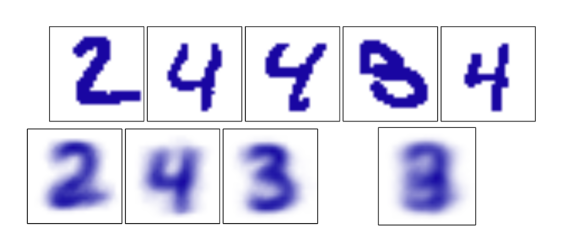

In [15]:
# 图9.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.10.png')
plt.axis('off')
ax.imshow(d)

图 9.10 伯努利混合模型的例子。上面一行给出了将手写数字数据集从灰度图转化为二值图之后的例子，转化时使用的阈值为0.5。下面一行中，最开始的三张图像展示了混合模型的三个分量的参数$ \mu_{ki} $。作为对比，我们也使用一个单一的多元伯努利分布对同样的数据进行了拟合，同样使用了最大似然方法。这对应于将每个像素点求平均，结果如下面一行最右侧的图所示。

这里，数字的图像被转化为了二值向量，转化的方法是令所有超过0.5的值等于1，令其他的值等于0。我们现在有$ N = 600 $张这样的图像，由数字“2”、“3”、“4”组成。我们将$ K = 3 $个伯努利分布进行混合，运行EM算法进行10轮迭代。混合系数被初始化为$ \pi = 1 $，参数$ \mu_{kj} $被设置为服从区间$ (0.25, 0.75) $上的均匀分布，且满足限制$ \sum_j \mu_{kj} = 1 $的随机值。我们看到，三个伯努利分布的混合能够找到数据里里对应于不同数字的三个聚类。

伯努利分布参数的共轭先验是Beta分布。我们已经看到一个Beta先验分布等价于引入$ x $的额外的有效观测。类似地，我们可以引入伯努利混合模型的先验分布，然后使用EM算法最大化后验概率分布。

很容易将对伯努利混合模型的分析推广到具有$ M > 2 $个状态的离散变量多项式分布的情形（由式(2.26)定义）。与之前一样，在必要的情况下，我们可以引入模型参数的狄利克雷先验分布。



In [6]:
# preparation
x, y = fetch_openml("mnist_784", return_X_y=True)
x_train = []
for i in [0, 1, 2, 3, 4]:
    x_train.append(x[np.random.choice(np.where(y == str(i))[0], 200)])
x_train = np.concatenate(x_train, axis=0)
x_train = (x_train > 127).astype(np.float)

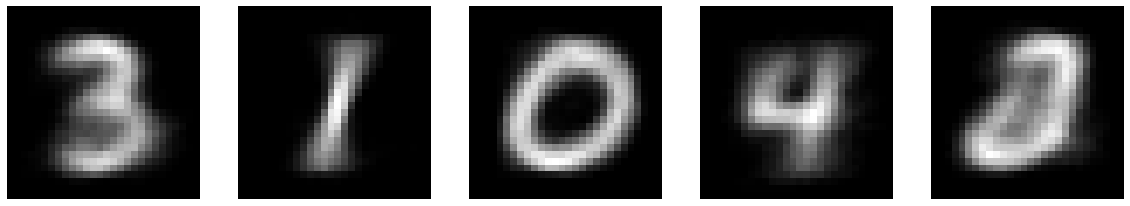

In [7]:
# plot
bmm = BernoulliMixture(n_components=5)
bmm.fit(x_train)

plt.figure(figsize=(20, 5))
for i, mean in enumerate(bmm.mu):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mean.reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()

## 9.3.4 贝叶斯线性回归的EM算法

作为说明EM算法应用的第三个例子，我们回到贝叶斯线性回归的证据近似问题。在3.5.2 节，我们通过计算模型证据然后令导数等于零的方式得到了超参数$ \alpha,\beta $的值。我们现在使用另一种寻找$ \alpha,\beta $的方法，这种方法基于EM算法。回忆一下，我们的目标是关于$ \alpha,\beta $最大化由式（3.77）给出的证据函数$ p(t| \alpha, \beta) $。由于参数$ w $已经被积分出去，因此我们可以将其当做一个潜在变量，因此我们可以使用EM算法来优化边缘似然函数。在E步骤中，我们计算在给定当前的$ \alpha,\beta $的条件下，$ w $的后验概率分布，然后使用这个找到完整数据对数似然函数的期望。在M步骤中，我们关于$ \alpha,\beta $最大化这个量。我们已经推导出了$ w $的后验概率分布，即式（3.49）。这样，完整数据的对数似然函数为
$ \ln p(t,w|\alpha,\beta) = \ln p(t|w,\beta) + \ln p(w|\alpha) \tag{9.61} $
其中似然函数$ p(t|w, \beta) $和先验概率分布$ p(w|\alpha) $分别由式（3.10）和式（3.52）给出。关于$ w $的后验概率分布取期望，可得
$ \begin{eqnarray} \mathbb{E}[\ln p(t,w|\alpha,\beta)] = & & \frac{M}{2}\ln\left(\frac{\alpha}{2\pi}\right) - \frac{\alpha}{2}\mathbb{E}[w^Tw] + \frac{N}{2}\ln\left(\frac{\beta}{2\pi}\right) \ &-& \frac{\beta}{2}\sum\limits_{n=1}^N\mathbb{E}[(t_n - w^t\phi_n)^2] \tag{9.62} \end{eqnarray} $
令它关于$ \alpha $的导数等于0，我们得到了M步骤的重新估计方程
$ \alpha = \frac{M}{\mathbb{E}[w^Tw]} = \frac{M}{m_N^Tm_N + Tr(S_N)} \tag{9.63} $
对于$ beta $，结果类似。
注意，这个重新估计方程与直接从证据函数推导出的对应的结果（3.92）的形式稍有不同。然而，两种形式都涉及到了对一个$ M \times M $的矩阵进行计算、求逆（或特征分解），因此在每轮迭代时的计算代价是可比的。



这两种确定$ \alpha $的方法显然应该收敛到同样的结果（假设它们找到证据函数的同一个局部极大值）。可以用下面的方法验证。首先注意到$ \gamma $的定义为
$ \gamma = M - \alpha\sum\limits_{i=1}^M\frac{1}{\lambda_i + \alpha} = M - \alpha Tr(S_N) \tag{9.64} $
在证据函数的驻点处，重估计方程（3.92）一定成立，因此我们可以将$ \gamma $替换掉，得到
$ \alpha m_N^Tm_N = \gamma = M - \alpha Tr(S_N) \tag{9.65} $
解出$ \alpha $，我们得到了式（9.63）的结果，这就是EM的重新估计方程。

作为最后一个例子，我们考虑一个密切相关的模型，即7.2.1节讨论的用于回归问题的相关向量机。那里，我们直接最大化边缘似然函数来推导超参数$ \alpha,\beta $的重估计方程。这里，我们考虑另一种方法，即把权向量$ w $看成一个潜在变量，然后使用EM算法。E步骤涉及到寻找权值的后验概率分布，这由公（7.81）给出。在M步骤中，我们最大化完整数据对数似然函数的期望，定义为
$ \mathbb{E}[\ln{p(t|X,w,\beta)p(w|\alpha(}] \tag{9.66} $
其中期望值是关于使用旧的参数计算的后验概率分布进行计算的。为了计算新的参数值，我们关于$ \alpha,\beta $进行最大化，有
$ \begin{eqnarray} \alpha_i^{new} &=& \frac{1}{m_i^2 + \Sigma_{ii}} \tag{9.67} \\ (\beta^{new})^{-1} &=& \frac{\Vert t - \Phi m \Vert^2 + \beta{-1}\sum_i\gamma_i}{N} \tag{9.68} \end{eqnarray} $
这些重估计方程在形式上等价于直接对边缘似然函数进行最大化得到的重估计方程。




# 9.4 一般形式的EM算法

期望最大化算法，或EM算法，是寻找具有潜在变量的概率模型的最大似然解的一种通用的方法（Dempster et al., 1977; MaLachlan and Krishnan, 1997）。这里，我们给出一般的EM算法，并且在这个过程中，会证明9.2节和9.3节在讨论高斯混合模型时启发式地推导出的EM算法确实最大化了似然函数（Csiszar and Tusnady, 1984; Hathaway, 1986; Neal and Hinton, 1999）。我们的讨论也构成了变分推断框架推导的基础。
考虑一个概率模型，其中我们将所有的观测变量联合起来记作$ X $，将所有的隐含变量记作$ Z $。联合概率分布$ p(X,Z|\theta) $由一组参数控制，记作$ \theta $。我们的目标是最大化似然函数
$ p(X|\theta) = \sum\limits_Zp(X,Z|\theta) \tag{9.69} $
这里，我们假设$ Z $是离散的，不过当$ Z $是连续变量或者离散变量与连续变量的组合时，方法是完全相同的，只需把求和换成适当的积分即可。
我们假设直接最优化$ p(X|\theta) $比较困难，但是最优化完整数据似然函数$ p(X,Z|\theta) $就容易得多。接下来，我们引入一个定义在潜在变量上的分布$ q(Z) $。我们观察到，对于任意的$ q(Z) $下面的分解成立
$ \ln p(X|\theta) = L(q,\theta) + KL(q \Vert p) \tag{9.70} $
其中，我们定义了
$$
\begin{aligned}
\mathcal{L}(q, \boldsymbol{\theta}) &=\sum_{\boldsymbol{Z}} q(\boldsymbol{Z}) \ln \left\{\frac{p(\boldsymbol{X}, \boldsymbol{Z} \mid \boldsymbol{\theta})}{q(\boldsymbol{Z})}\right\} \\
\mathrm{KL}(q \| p) &=-\sum_{\boldsymbol{Z}} q(\boldsymbol{Z}) \ln \left\{\frac{p(\boldsymbol{Z} \mid \boldsymbol{X}, \boldsymbol{\theta})}{q(\boldsymbol{Z})}\right\}
\end{aligned}
\tag{9.71,9.72} $$
注意，$ L(q, \theta) $是概率分布$ q(Z) $的一个泛函（关于泛函的讨论，见附录D），并且是参数$ \theta $的一个函数。值得仔细研究的是表达式（9.71）和（9.72）的形式，特别地，需要注意，二者的符号相反，并且$ L(q, \theta) $包含了$ X, Z $的联合概率分布，而$ KL(q \Vert p) $包含了给定$ X $的条件下，$ Z $的条件分布。为了验证式（9.70）给出的分解方式，我们首先使用概率的乘积规则，可得
$ \ln p(X,Z|\theta) = \ln p(Z|X,\theta) + \ln p(X|\theta) \tag{9.73} $
然后代入$ L(q, \theta) $的表达式。这得到了两项，一项消去了$ KL(q \Vert p) $，而另一项给出了所需的对数似然函数$ \ln p(X | \theta) $，其中我们用到了归一化的概率分布$ q(Z) $的积分等于1的事实。
根据式（9.72），我们看到$ KL(q \Vert p) $是$ q(Z) $和后验概率分布$ p(Z|X, \theta) $之间的Kullback-Leibler散度。 回忆一下，Kullback-Leibler散度满足$ KL(q \Vert p) \geq 0 $，当且仅当$ q(Z) = p(Z|X, \theta) $时等号成立。因此，根据式（9.70），$ L(q, \theta) \leq \ln p(X|\theta) $，换句话说，$ L(q, \theta) $是$ \ln p(X|\theta) $的一个下界。图9.11说明了式（9.70）的分解。
 

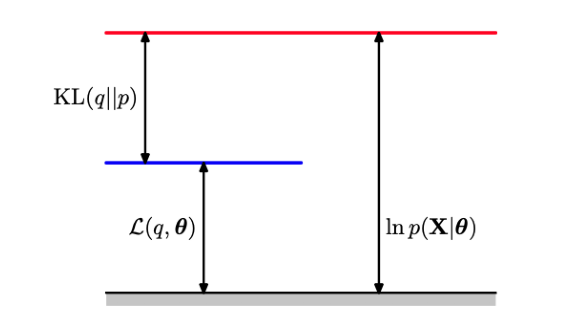

In [16]:
# 图9.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.11.png')
plt.axis('off')
ax.imshow(d)

图 9.11 由式（9.70）给出的分解的说明，它对于分布$ q(Z) $的任意选择都成立。由于Kullback-Leibler散 度满足$ KL(q \Vert p) \geq 0 $，因此我们看到$ L(q, \theta) $是对数似然函数$ \ln p(X | \theta) $的下界。

EM算法是一个两阶段的迭代优化算法，用于寻找最大似然解。我们可以使用式（9.70）来定义EM算法，证明它确实最大化了对数似然函数。假设参数向量的当前值为$ \theta^{old} $。在E步骤中，下界$ L(q, \theta^{old}) $关于$ q(Z) $被最大化，而$ \theta^{old} $保持固定。最大化问题的解很容易看出来。我们注意到$ \ln p(X|\theta^{old}) $不依赖于$ q(Z) $，因此$ L(q, \theta^{old}) $的最大值出现在Kullback-Leibler散度等于0的时候，换句话说，最大值出现在$ q(Z) $与后验概率分布$ p(Z | X, \theta^{old}) $相等的时候。此时，下界等于对数似然函数，如图9.12所示。

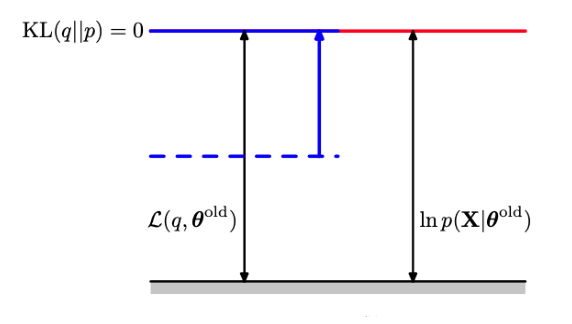

In [17]:
# 图9.12
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.12.png')
plt.axis('off')
ax.imshow(d)


 图 9.12 EM算法的E步骤的说明。$ q $分布被设置为当前参数值$ \theta^{old} $下的后验概率分布，这使得下界上移到与对数似然函数值相同的位置，此时KL散度为零。

在接下来的M步骤中，分布$ q(Z) $保持固定，下界$ L(q, \theta) $关于$ \theta $进行最大化，得到了某个新值$ \theta^{new} $。这会使得下界L增大（除非已经达到了极大值），这会使得对应的对数似然函数增大。由于概率分布$ q $由旧的参数值确定，并且在M步骤中保持固定，因此它不会等于新的后验概率分布$ p(Z|X, \theta^{new}) $，从而KL散度非零。于是，对数似然函数的增加量大于下界的增加量，如图9.13所示。
 

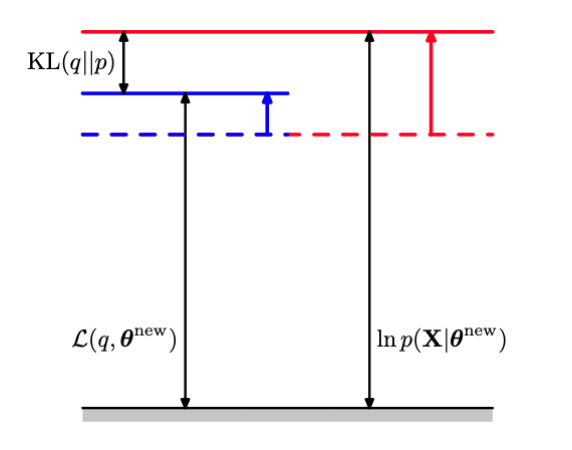

In [18]:
# 图9.13
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.13.png')
plt.axis('off')
ax.imshow(d)

图 9.13 EM算法的M步骤的说明。分布$ q(Z) $保持固定，下界$ L(q, \theta) $关于参数向量$ \theta $最大化，得到修正值$ \theta^{new} $。由于KL散度非负，因此这使得对数似然函数$ \ln p(X|\theta) $的增量至少与下界的增量相等。
如果我们将$ q(Z) = p(Z|X, \theta^{old}) $代入式（9.71），我们会看到，在E步骤之后，下界的形式为
$ \begin{eqnarray} L(q,\theta) &=& \sum\limits_Zp(Z|X,\theta^{old})\ln p(X,Z|\theta) - \sum\limits_Zp(Z|X,\theta^{old})\ln p(Z|X,\theta^{old}) \ &=& Q(\theta,\theta^{old}) + const \tag{9.74} \end{eqnarray} $
其中，常数就是分布$ q $的熵，因此与$ \theta $无关。从而在M步骤中，最大化的量是完整数据对数似然函数的期望，正如我们之前在混合高斯模型的情形中看到的那样。注意，我们进行优化的变量$ \theta $只出现在对数运算内部。如果联合概率分布$ p(Z, X | \theta) $由指数族分布的成员组成，或者由指数族分布成员的乘积组成，那么我们看到对数运算会抵消指数运算，从而使得M步骤通常比最大化对应的不完整数据对数似然函数$ p(X|\theta) $要容易得多。

EM算法的计算也可以被看做参数空间中的运算，如图9.14所示。

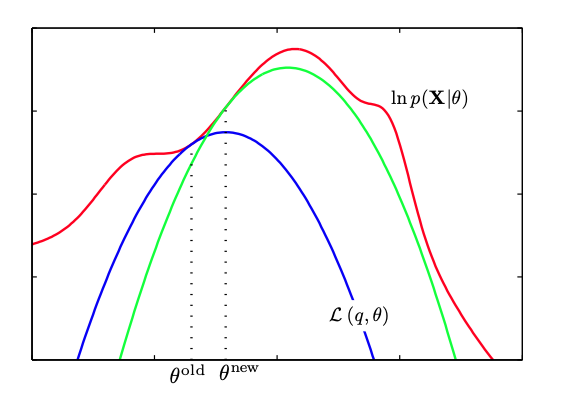

In [19]:
# 图9.14
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图9.14.png')
plt.axis('off')
ax.imshow(d)

图 9.14 EM算法涉及到交替计算当前参数值下的对数似然函数的下界以及最大化下界的值得到新的参数值。

这里，红色曲线表示（不完整数据）对数似然函数，它的最大值是我们想要得到的。我们首先选择某个初始的参数值$ \theta^{old} $，然后在第一个E步骤中，我们计算潜在变量上的后验概率分布，得到了$ L(q, \theta^{old} $)的一个更小的下界，它的值等于在$ \theta^{old} $处的对数似然函数值，用蓝色曲线表示。注意，下界与对数似然函数在$ \theta^{old} $处以切线的方式连接，因此两条曲线的梯度相同。这个界是一个凹函数，对于指数族分布的混合分布来说，有唯一的最大值。在M步骤中，下界被最大化，得到了新的值$ \theta^{new} $，这个值给出了比$ \theta^{old} $处更大的对数似然函数值。接下来的E步骤构建了一个新的下界，它在$ \theta^{new} $处与对数似然函数切线连接，用绿色曲线表示。


对于独立同分布数据集的特殊情形，$ X $由$ N $个数据点$ {x_n} $组成，而$ Z $由$ N $个对应的潜在变量$ {z_n} $组成，其中$ n = 1,...,N $。根据独立性假设，我们有$ p(X, Z) = \prod_np(x_n, z_n) $，并且通过关于$ {z_n} $求边缘概率分布，我们有$ p(X) = \prod_n p(x_n) $。使用加法规则和乘法规则，我们看到在E步骤中计算的后验概率分布的形式为
$ p(Z|X,\theta) = \frac{p(X,Z|\theta)}{\sum\limits_Zp(X,Z|\theta)} = \frac{\prod\limits_{n=1}^Np(x_n,z_n|\theta)}{\sum\limits_Z\prod\limits_{n=1}^Np(x_n,z_n|\theta)} = \prod\limits_{n=1}^Np(z_n|x_n,\theta) \tag{9.75} $
因此后验概率分布也可以关于$ n $进行分解。在高斯混合模型的情形中，这个结果意味着混合分布的每个分量对于一个特定的数据点$ x_n $的“责任”只与$ x_n $的值和混合分量的参数$ \theta $有关，而与其他数据点无关。
我们已经看到，EM算法的E步骤和M步骤都增大了对数似然函数的一个良好定义的下界的值，并且完整的EM循环会使得模型的参数向着使对数似然函数增大的方向进行改变（除非已经达到了一个极大值，此时参数保持不变）。
我们也可以使用EM算法来最大化模型的后验概率分布$ p(\theta|X) $，其中我们已经引入了参数上的先验概率分布$ p(\theta) $。为了理解这一点，我们注意到作为一个$ \theta $的函数，我们有$ p(\theta|X) = p(\theta, X) / p(X) $，因此
$ \ln p(\theta|X) = \ln p(\theta,X) - \ln p(X) \tag{9.76} $
使用式（9.70）的分解，我们有
$ \begin{eqnarray} \ln p(\theta|X) &=& L(q,\theta) + KL(q \Vert p) + \ln p(\theta) - \ln p(X) \ &\geq& L(q,\theta) + \ln p(\theta) - \ln p(X) \tag{9.77} \end{eqnarray} $
其中$ \ln p(X) $是一个常数。同样的，我们可以交替地关于$ q, \theta $对右侧进行优化。因为$ q $只出现在$ L(q, \theta) $中，所以关于$ q $的优 化产生了与标准EM算法相同的E步骤。M步骤的方程通过引入先验项$ \ln p(\theta) $进行修改，这通常只需要对标准的最大似然M步骤的方程进行很小的修改即可。

EM算法将最大化似然函数这一困难的问题分解成了两个阶段，即E步骤和M步骤，每个步骤都很容易实现。尽管这样，对于复杂的模型来说，E步骤或者M步骤仍然无法计算。这就引出了对EM算法的两个扩展，叙述如下。
广义EM算法（generalized EM algorithm），或者简称GEM算法，解决的是M步骤无法计算的问题。这个算法不去关于$ \theta $最大化$ L(q, \theta) $，而是改变参数的值去增大$L(q,\theta) $的值。同样的，由于$ L(q, \theta) $是对数似然函数的一个下界，因此GEM算法的完整的EM循环保证了对数似然函数值的增大（除非参数已经对应于一个局部极大值）。一种使用GEM的方法是在M步骤中使用某种非线性最优化策略，例如共轭梯度算法。另一种形式的GEM算法，被称为期望条件最大化算法（expectation conditional maximization algorithm），或者简称ECM算法，涉及到在每个M步骤中进行若干了具有限制条件的最优化（Meng and Rubin， 1993）。例如，参数可能被划分为若干组，并且M步骤被划分成多个步骤，每个步骤最优化一个子集，同时保持其他的子集固定。



类似地，我们可以用下面的方法推广EM算法中的E步骤：对$ L(q, \theta) $关于$ q(Z) $进行一个部分的最优化而不是完全的最优化（Neal and Hinton， 1999）。正如我们已经看到的，对于任意给定的$ \theta $值，$ L(q, \theta) $关于$ q(Z) $有一个唯一的最大值，它对应于后验概率分布$ q_{\theta}(Z) = p(Z | X, \theta) $， 并且对于这个$ q(Z) $的选择，下界$ L(q, \theta) $等于对数似然函数$ L(q, \theta) $。因此任何收敛于$ L(q, \theta) $的全局最大值的算法都会找到一个$ \theta $值，这个值也是对数似然函数$ \ln p(X | \theta) $的全局最大值。 只要$ p(X, Z | \theta) $是$ \theta $的一个连续函数，那么根据连续性，$ L(q, \theta) $的任意一个局部极大值也会是$ \ln p(X | \theta) $的一个局部极大值。

考虑N个独立数据点$ x_1,...,x_N $对应于潜在变量$ z_1,...,z_N $的情形。 联合概率分布$ p(X, Z | \theta) $可以在数据点上进行分解，并且这个结构可以被增量形式的EM算法利用，即在每个EM循环中，只处理一个数据点。在E步骤中，我们不重新计算所有数据点的“责任”，而是只重新计算一个数据点的“责任”。似乎接下来的M步骤会需要涉及到所有数据点的“责任”的计算。但是，如果混合的分量是指数族分布的成员，那么“责任”只出现在简单的充分统计量之中，这些量可以高效地更新。例如，考虑高斯混合分布的情形，假设我们对数据点m进行了一个更新，其中对应的“责任”的旧值和新值分别为$ \gamma^{old}(z_{mk}) $和$ \gamma^{new}(z_{mk}) $。在M步骤中，所需的充分统计量可以增量地更新。例如，对于均值来说，充分统计量由式（9.17）和式（9.18）定义，因此我们可以得到
$ \mu_k^{new} = \mu_k^{old} + \left(\frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N_k^{new}}\right)\left(x_m - \mu_k^{old}\right) \tag{9.78} $
以及
$ N_k^{new} = N_k^{old} + \gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk}) \tag{9.79} $
对应的协方差和混合系数的结果与此类似。

因此E步骤和M步骤的计算时间都与数据点的总数无关。由于参数在每个数据点被使用之后进行修改，而不是等到全部数据处理完毕之后才进行又该，因此以批处理版本相比，这个增量版本的收敛速度更快。这个增量算法中的每个E步骤或者M步骤都会增大$ L(q, \theta) $的值，并且正如我们之前说明的那样，如果算法收敛于$ L(q, \theta ) $的一个局部的（或全局的）最大值，那么这会对应于对数似然函数$ \ln p(X|\theta) $的一个局部的（或全局的）最大值。